In [13]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D,  MaxPooling1D, BatchNormalization, GlobalMaxPooling1D

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [14]:
def load_audio(file_path):
  audio = tfio.audio.AudioIOTensor(file_path)
  return tf.squeeze(audio.to_tensor(), axis=-1), audio.rate.numpy()

def get_label(file_path):
  parts = re.sub('.+\_|[0-9]+.wav', '', file_path)
  return parts

In [15]:
DATA_DIR = "./data/SAVEE"

filenames = [(f'{DATA_DIR}/{p}', p) for p in os.listdir(DATA_DIR)]
df = pd.DataFrame([(f, *load_audio(filename), get_label(filename)) for (filename, f) in filenames], columns=['file', 'audio_tensor', 'rate', 'label']).set_index('file')
if len(df['rate'].unique()) > 1:
  raise Exception('Different rates in the dataset')
rate = df['rate'][0]
df.drop('rate', inplace=True, axis=1)
# crop data to the first 8 seconds
df['cropped'] = df['audio_tensor'].map(lambda x: x[:rate * 8])
df['padded'] = df['cropped'].map(lambda x: tf.convert_to_tensor(np.pad(x, (0, rate * 8 - len(x)), 'constant')))

print(f"{np.count_nonzero(df['audio_tensor'].map(lambda x: x.shape[0]) > rate * 8)} elements cropped")
df.head()

0 elements cropped


,audio_tensor,label,cropped,padded
file,,,,
JK_a13.wav,"(tf.Tensor(273, shape=(), dtype=int16), tf.Ten...",a,"(tf.Tensor(273, shape=(), dtype=int16), tf.Ten...","(tf.Tensor(273, shape=(), dtype=int16), tf.Ten..."
JE_n14.wav,"(tf.Tensor(1303, shape=(), dtype=int16), tf.Te...",n,"(tf.Tensor(1303, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1303, shape=(), dtype=int16), tf.Te..."
DC_n16.wav,"(tf.Tensor(1360, shape=(), dtype=int16), tf.Te...",n,"(tf.Tensor(1360, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1360, shape=(), dtype=int16), tf.Te..."
KL_n30.wav,"(tf.Tensor(48, shape=(), dtype=int16), tf.Tens...",n,"(tf.Tensor(48, shape=(), dtype=int16), tf.Tens...","(tf.Tensor(48, shape=(), dtype=int16), tf.Tens..."
DC_d12.wav,"(tf.Tensor(1308, shape=(), dtype=int16), tf.Te...",d,"(tf.Tensor(1308, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1308, shape=(), dtype=int16), tf.Te..."


In [16]:
train_files = df.iloc[:300]
val_files = df.iloc[300: 300 + 100]
test_files = df.iloc[-80:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
test_files.head()

Training set size 300
Validation set size 100
Test set size 80


,audio_tensor,label,cropped,padded
file,,,,
KL_a06.wav,"(tf.Tensor(161, shape=(), dtype=int16), tf.Ten...",a,"(tf.Tensor(161, shape=(), dtype=int16), tf.Ten...","(tf.Tensor(161, shape=(), dtype=int16), tf.Ten..."
JK_h11.wav,"(tf.Tensor(1645, shape=(), dtype=int16), tf.Te...",h,"(tf.Tensor(1645, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1645, shape=(), dtype=int16), tf.Te..."
JK_f07.wav,"(tf.Tensor(1284, shape=(), dtype=int16), tf.Te...",f,"(tf.Tensor(1284, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1284, shape=(), dtype=int16), tf.Te..."
JE_n04.wav,"(tf.Tensor(1300, shape=(), dtype=int16), tf.Te...",n,"(tf.Tensor(1300, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1300, shape=(), dtype=int16), tf.Te..."
JK_d10.wav,"(tf.Tensor(1653, shape=(), dtype=int16), tf.Te...",d,"(tf.Tensor(1653, shape=(), dtype=int16), tf.Te...","(tf.Tensor(1653, shape=(), dtype=int16), tf.Te..."


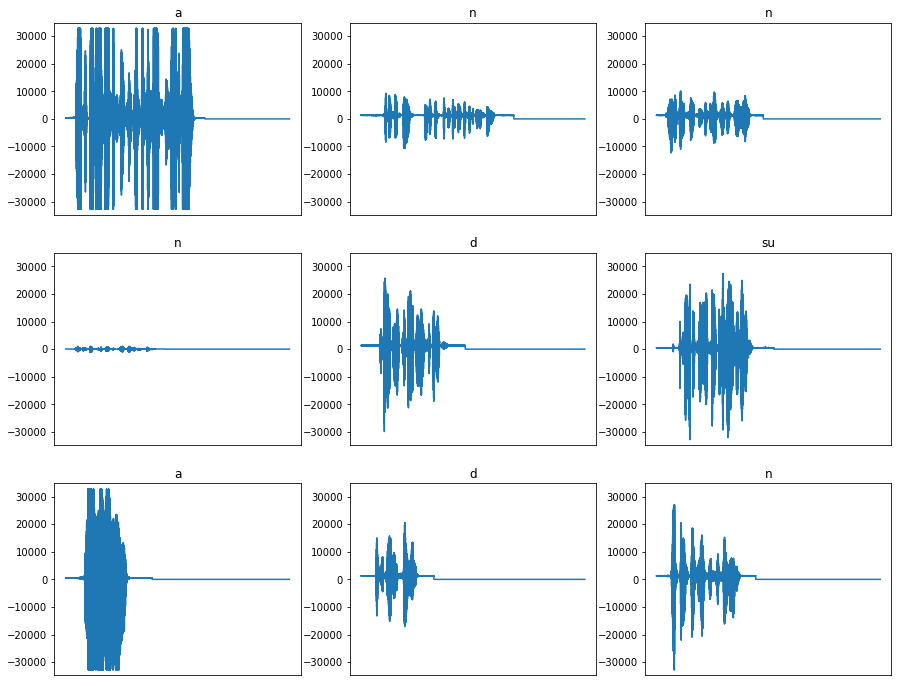

In [21]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

to_plot = df.iloc[:n]
max, min = to_plot['padded'].map(lambda x: x.numpy().max()).max(), to_plot['padded'].map(lambda x: x.numpy().min()).min()

for i, (_, row) in enumerate(to_plot.iterrows()):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(row['padded'].numpy())
  ax.set_ylim(ymin=min-2000, ymax=max+2000)
  label = row['label']
  ax.set_xticks([])
  ax.set_title(label)

plt.show()

In [18]:
first_filter_size =  (32, 21)
filters = [64, 128, 256, 512, 1024]
sizes = [19, 17, 15, 13, 11]
middle_filters_size = list(zip(filters, sizes))

activation= 'relu'
pool_size = 2

last_filter_size =  (1024, 9)

In [19]:
# input_shape = (4, 10)
# x = tf.random.normal(input_shape)
# y = tf.keras.layers.Conv1D(1, 1, activation='relu',input_shape=(None,10))(x)
# x

In [22]:
#  1D + Batch norm + max pooling          x 6 ok
#  1D + Batch norm + global max pooling   x 1 ok
#  dense layer                            x 2

model = Sequential()

# first layer
# input shape (None, n) = variable-length sequences of n-dimensional vectors
model.add(Conv1D(first_filter_size[0], first_filter_size[1], activation = activation, input_shape=(8 * 44100, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = pool_size))

# # middle layers
for (filter_size, kernel_size) in middle_filters_size:
    model.add(Conv1D(filter_size, kernel_size, activation = activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = pool_size))

# # last layer
model.add(Conv1D(last_filter_size[0], last_filter_size[1], activation = activation))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation=activation))
model.add(Dense(7, activation='softmax'))

model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 352780, 32)        704       
                                                                 
 batch_normalization (BatchN  (None, 352780, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176390, 32)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 176372, 64)        38976     
                                                                 
 batch_normalization_1 (Batc  (None, 176372, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:

# h = model.fit(train_files['audio_tensor'], train_files['label'], epochs=10, validation_data=(val_files['audio_tensor'], val_files['label']))
type(tf.convert_to_tensor(train_files))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).